In [1]:
# INSTALLATION PYSPICE
# pip install pyspice
# pyspice-post-installation --install-ngspice-dll


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Unit import *

In [3]:
R=11
L=32e-3
#L=L*10
f=50
Vdc=0
Vac=24
w=2*np.pi*f

circuitRL = Circuit('AC on RL')
R1=circuitRL.R('1',  'supply', 'output',R@u_Ω)
L1=circuitRL.L('1',  'output', 0,L@u_H)
#L1=circuit.L('1',  'output', 0, f' SATL {L} ')

circuitRL.V('1',0,'supply', f'DC {Vdc} AC {Vac} SIN(0 {Vac} {f})')
#.MODEL <model name> IND [model parameters]
#circuit.model('SATL', 'L', L=1, IL1=1, IL2=-0.1)
    
L1.plus.add_current_probe(circuitRL)

ZL=w*L
ZL

10.053096491487338

In [4]:
dt = 0.1e-3
tf = 5/f
simulator = circuitRL.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=dt@u_s, end_time=tf@u_s)

In [5]:
print(circuitRL)

.title AC on RL
R1 supply output 11Ohm
L1 L1_plus 0 0.032H
V1 0 supply DC 0 AC 24 SIN(0 24 50)
VL1_plus output L1_plus 0



In [6]:
print(circuitRL.VL1_plus)

VL1_plus output L1_plus 0


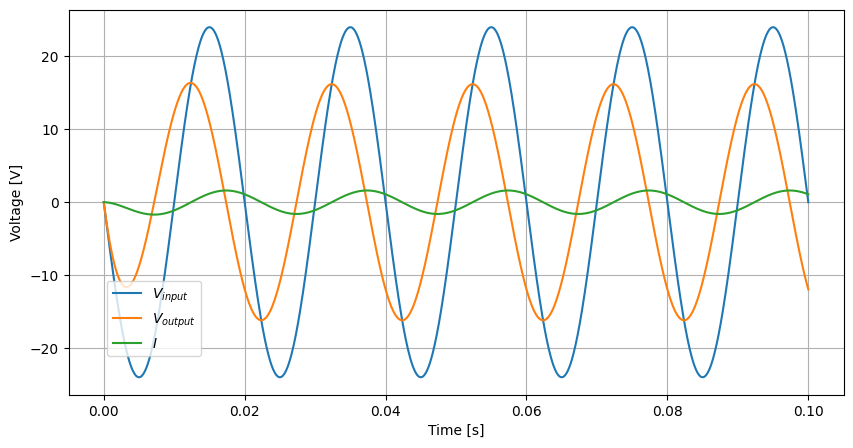

In [7]:
#| fig-cap: Simulation of a RL circuit
#| label: fig-RL-simulation

figure1, ax = plt.subplots(figsize=(10, 5))
#ax.set_title('Voltage Divider')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]')
ax.grid()
ax.plot(analysis.time,analysis.supply)
ax.plot(analysis.time,analysis.output)
ax.plot(analysis.time,analysis.VL1_plus)
ax.legend(('$V_{input}$', '$V_{output}$', '$I$'), loc=(.05,.1))
#plt.tight_layout()
plt.show()

In [8]:
R=11
C=250e-6
f=50
Vdc=0
Vac=24
w=2*np.pi*f

circuitRC = Circuit('AC on RC')
R1=circuitRC.R('1',  'supply', 'output',R@u_Ω)
C1=circuitRC.C('1',  'output', 0,C@u_F)
circuitRC.V('1',0,'supply', f'DC {Vdc} AC {Vac} SIN(0 {Vac} {f})')
    
C1.plus.add_current_probe(circuitRC)

ZC=1/(w*C)
ZC

12.732395447351628

In [9]:
dt = 0.1e-3
tf = 5/f
simulator = circuitRC.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=dt@u_s, end_time=tf@u_s)

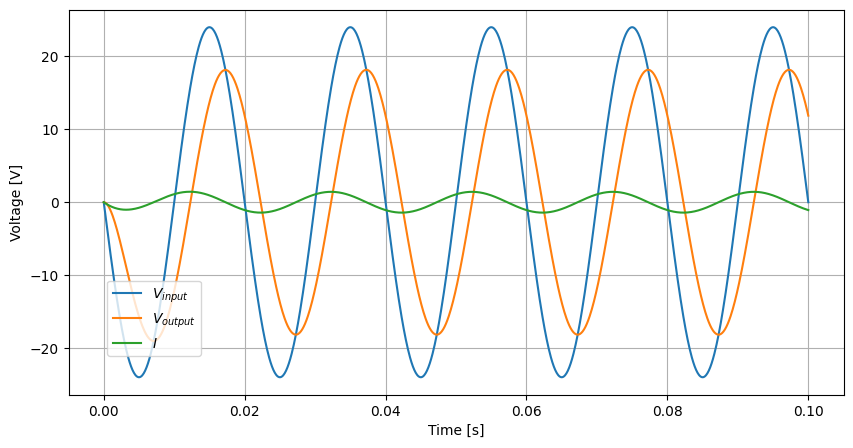

In [10]:
#| fig-cap: Simulation of a RC circuit
#| label: fig-RC-simulation
figure1, ax = plt.subplots(figsize=(10, 5))
#ax.set_title('Voltage Divider')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]')
ax.grid()
ax.plot(analysis.time,analysis.supply)
ax.plot(analysis.time,analysis.output)
ax.plot(analysis.time,analysis.VC1_plus)
ax.legend(('$V_{input}$', '$V_{output}$', '$I$'), loc=(.05,.1))
#plt.tight_layout()
plt.show()

## Calculs de puissance

In [11]:
# Récupère les données de la dernière période
temps=np.array(analysis.time)
I=np.where(temps>(temps[-1]-0.04+dt))

In [12]:
N=len(I[0])

In [13]:
Udata=np.array(analysis.supply[I])
Odata=np.array(analysis.output[I])
Idata=np.array(analysis.VC1_plus[I])

In [14]:
Tdata=temps[I]

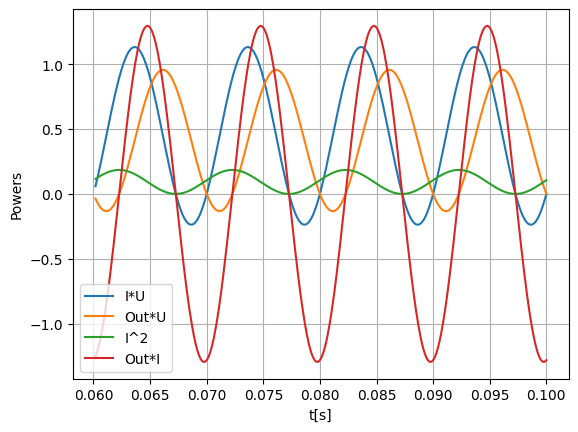

In [15]:
plt.plot(Tdata,Idata*Udata/25)
plt.plot(Tdata,Odata*Udata/400)
plt.plot(Tdata,Idata*Idata/R)
plt.plot(Tdata,Idata*Odata/10)
plt.xlabel("t[s]")
plt.ylabel("Powers")
plt.legend(("I*U","Out*U", "I^2","Out*I"))
plt.grid()
plt.show()

## Calculs des puissances moyennes

In [16]:
# Puissance sur la résistance
(np.sum(Idata**2)/N*R)

np.float64(11.18963216404978)

In [17]:
#Puissance comme produit u x i
np.sum(Idata*Udata)/N

np.float64(11.189383068747004)

In [18]:
# Relation entre courant simulé et calcul d'impédance complexe
I_crete=np.max(Idata)
ZC=1j/(w*C)
Z=ZC+R
ZC
I_calc=np.abs(Vac/Z)
[I_crete, I_calc]

[np.float64(1.4264304757607076), np.float64(1.426364923253269)]

## Calculs des harmoniques

TODO : introduire une non-linéarité, le modèle de la diode ne fonctionne pas

In [19]:
R=11
Rd=5
C=250e-6
f=50
Vdc=0
Vac=24
w=2*np.pi*f

from PySpice.Physics.SemiConductor import ShockleyDiode

#libraries_path = find_libraries()
#spice_library = SpiceLibrary(libraries_path)
circuitDRC = Circuit('AC on RC')
#circuitDRC.include(spice_library['1N4148'])
R1=circuitDRC.R('1',  'supply', 'output',R@u_Ω)
C1=circuitDRC.C('1',  'output', 0,C@u_F)
#D=circuitDRC.D('1', '1N4148', 'supply', 2)
#R2=circuitDRC.R('2', 2, 'output',Rd@u_Ω)
circuitDRC.V('1',0,'supply', f'DC {Vdc} AC {Vac} SIN(0 {Vac} {f})')
    
C1.plus.add_current_probe(circuitDRC)

ZC=1/(w*C)
ZC

12.732395447351628

In [20]:
dt = 0.1e-3
tf = 5/f
simulator = circuitDRC.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=dt@u_s, end_time=tf@u_s)

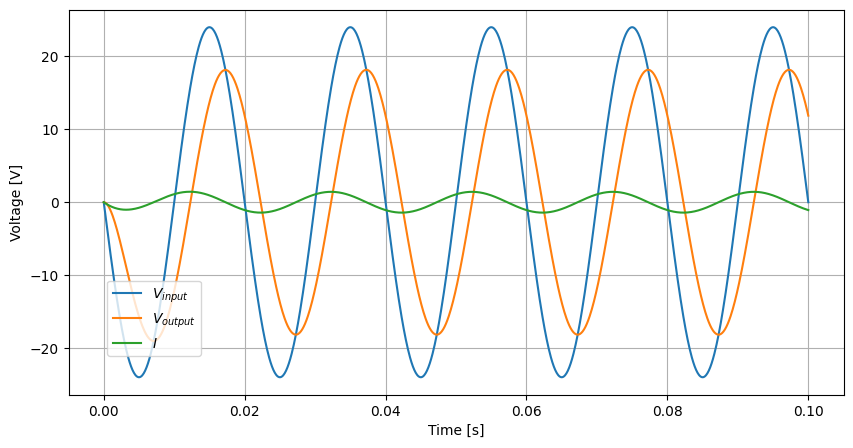

In [21]:
#| fig-cap: Simulation of a RC circuit
#| label: fig-DRC-simulation
figure1, ax = plt.subplots(figsize=(10, 5))
#ax.set_title('Voltage Divider')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]')
ax.grid()
ax.plot(analysis.time,analysis.supply)
ax.plot(analysis.time,analysis.output)
ax.plot(analysis.time,analysis.VC1_plus)
ax.legend(('$V_{input}$', '$V_{output}$', '$I$'), loc=(.05,.1))
#plt.tight_layout()
plt.show()

In [22]:
FFTU=np.abs(np.fft.fft(Udata))
FFTI=np.abs(np.fft.fft(Idata))